# Understanding the VAE NN with visualization tools

In [1]:
# Importing libraries
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt

# Importing dependencies and functions
from VAE.config import *
from VAE.autoencoder import *
from VAE.losses import *
from VAE.preprocessing_tools import *
from VAE.config import *

### The 3 phases of the neuronal network, design and understanding the code

In [2]:
# Encoder

img = tf.keras.layers.Input(shape=(28,28,1), name="input_image")

# Creating a partial model for the encoder
encoder_model_part = Encoder(input_shape=INPUT_IMAGE_SIZE,latent_dim=28)

# Calling the model
mu, sigma, conv_dim = encoder_model_part(img)
print('Mu shape is: ',mu.shape)
print('Sigma shape is: ',sigma.shape)
print('Conv_dim shape is: ',conv_dim)
encoder_model_part.summary()





Mu shape is:  (None, 28)
Sigma shape is:  (None, 28)
Conv_dim shape is:  KerasTensor(type_spec=TensorSpec(shape=(4,), dtype=tf.int32, name=None), inferred_value=[None, 7, 7, 64], name='encoder/Shape:0', description="created by layer 'encoder'")
Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encode_conv1 (Conv2D)       multiple                  320       
                                                                 
 batch_normalization (BatchN  multiple                 128       
 ormalization)                                                   
                                                                 
 encode_conv2 (Conv2D)       multiple                  18496     
                                                                 
 batch_normalization_1 (Batc  multiple                 256       
 hNormalization)                                                 
            

In [3]:
dir(conv_dim)
type(conv_dim._inferred_value)

list

In [4]:
decoder_model_part = Decoder(conv_shape=(None,28,28,1))
input_deco = tf.keras.layers.Input(shape=(28))
decoder_model_part(input_deco)
decoder_model_part.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decode_dense1 (Dense)       multiple                  22736     
                                                                 
 batch_normalization_3 (Batc  multiple                 3136      
 hNormalization)                                                 
                                                                 
 decode_dense1 (Dense)       multiple                  615440    
                                                                 
 batch_normalization_4 (Batc  multiple                 3136      
 hNormalization)                                                 
                                                                 
 decode_reshape (Reshape)    multiple                  0         
                                                                 
 decode_conv2d_2 (Conv2DTran  multiple                 640 

In [5]:
def show_images(output_tensor,display_shape=(5,5),figure_size=(5,5), show=False):
    if output_tensor.shape[0] > display_shape[0]*display_shape[1]:
        fig, ax = plt.subplots(display_shape[0],display_shape[1], figsize =figure_size)
        for row in range(display_shape[0]):
            for col in range(display_shape[1]):
                imag_number = row*display_shape[1] + col
                ax[row, col].imshow(output_tensor[imag_number], cmap='gray')
                #ax[row, col].set_title(str(imag_number))
        if show:
            plt.show()
        return fig
    else:
        print('Try to increase the batch size (the number of images),\n show_images>tensor_images')
    

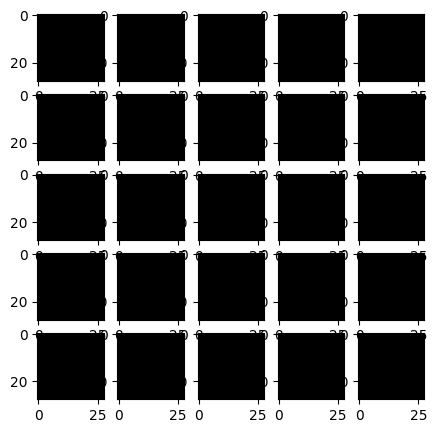

In [6]:
A = tf.fill([35,28,28,1], value=0)
b = np.full((28,28),250,dtype=np.uint8)
img = tf.cast(A[0],dtype=tf.uint8).numpy()
A = show_images(A)


In [7]:
#VAE, model_MNIST_generator, model_encoder = VAE_autoencoder(latent_dim_shape=28, image_shape=(28,28,1))
VAE, mnist_gen_model, encoder_model  = VAE_classes(latent_dim_shape=LATENT_DIMENSION, number_of_classes=NUMBER_OF_CLASSES, image_shape=INPUT_IMAGE_SIZE)

In [8]:
latest = tf.train.latest_checkpoint(os.path.join(MAIN_PATH,TRAIN_CHECKPOINTS_FOLDER))
VAE.load_weights(latest)


In [9]:
# Load the dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
assert x_train.shape == (60000, 28, 28)
assert x_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)

train = tf.data.Dataset.from_tensor_slices((x_train,y_train))
test = tf.data.Dataset.from_tensor_slices((x_test[:10],y_test[:10]))

# Preprocessing dataset images and labels
names = ['Zero','One','Two','Three','Four','Five','Six','Seven','Eigth','Nine']
one_hot_names = one_hot_encoder(names)
train = train.map(lambda x, y: (exp_dims(img_norm(x)), translate_to_hot_encoding(y, one_hot_names)),
                  num_parallel_calls=tf.data.AUTOTUNE)

test = test.map(lambda x, y: (exp_dims(img_norm(x)), translate_to_hot_encoding(y, one_hot_names)),
                num_parallel_calls=tf.data.AUTOTUNE)

#genetating the input data format
train = train.batch(TRAIN_BATCH).shuffle(TRAIN_SHUFFLE).prefetch(TRAIN_PREFETCH)
test = test.batch(TRAIN_BATCH).prefetch(TRAIN_PREFETCH)

In [10]:
trail_imag = train.as_numpy_iterator().next()

In [11]:
images_tensor = VAE([trail_imag])

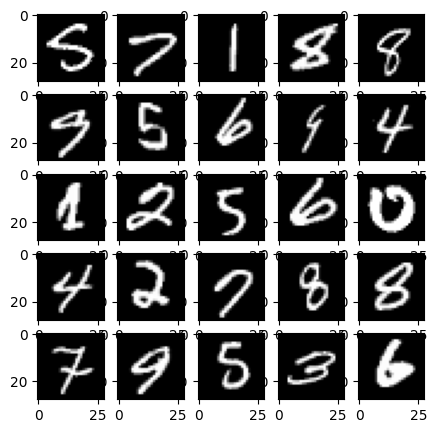

In [12]:
fig = show_images(trail_imag[0])

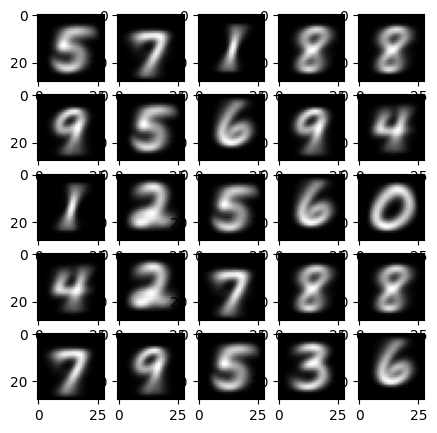

In [13]:
fig = show_images(images_tensor)

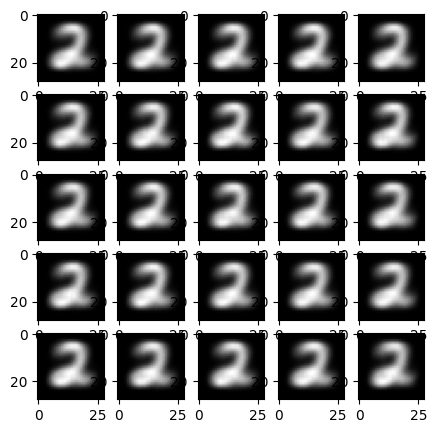

In [19]:
random_vector_for_generation = tf.random.normal(shape=[30, 28], mean=0.0, stddev=2.0)
numbers = tf.repeat(tf.Variable([[0,0,1,0,0,0,0,0,0,0]]),30,axis=0)
#out_gene = model_MNIST_generator([model_encoder(train.as_numpy_iterator().next()[0])[0],model_encoder(train.as_numpy_iterator().next()[0])[1]])
out_gene = mnist_gen_model([random_vector_for_generation,numbers])
fig = show_images(out_gene)

In [ ]:
from tqdm import tqdm, trange
from random import random, randint
from time import sleep

with trange(10) as t:
    for i in t:
        # Description will be displayed on the left
        t.set_description('GEN %i' % i)
        # Postfix will be displayed on the right,
        # formatted automatically based on argument's datatype
        t.set_postfix(loss=random(), gen=randint(1,999), str='h',
                        lst=[1, 2])
        sleep(0.5)

with tqdm(total=10, bar_format="{postfix[0]} {postfix[1][value]:>8.2g}",
          postfix=["Batch", {"value": 0}]) as t:
    for i in range(10):
        sleep(0.1)
        t.postfix[1]["value"] = i / 2
        t.update()

GEN 0:   0%|          | 0/10 [00:00<?, ?it/s, gen=449, loss=0.516, lst=[1, 2], str=h]

GEN 9: 100%|██████████| 10/10 [00:05<00:00,  1.98it/s, gen=519, loss=0.959, lst=[1, 2], str=h]
Batch      4.5


In [ ]:
epoch = range(10)

for e in epoch:
    with tqdm(test) as t:
        t.set_description('Epoch: {}/{},'.format(e+1,len(epoch)))
        for i in t:
            # Description will be displayed on the left
            # Postfix will be displayed on the right,
            # formatted automatically based on argument's datatype
            t.set_postfix(loss=random(), gen=randint(1,999), str='h',
                            lst=[1, 2])
            sleep(0.5)

Epoch: 10/10,: 100%|██████████| 1/1 [00:00<00:00,  1.94it/s, gen=836, loss=0.128, lst=[1, 2], str=h]


In [ ]:
loss = tf.keras.losses.BinaryCrossentropy(reduction='none')
random = tf.random.uniform(
                                shape = [2,10],
                                minval=0,
                                maxval=2,
                                dtype=tf.int32,
                            )
output = tf.random.uniform(
                                shape = [2,10],
                                minval=0,
                                maxval=1,
                                dtype=tf.float32,
                            )

In [ ]:
loss(random,output)

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([1.475491  , 0.63269436], dtype=float32)>

In [ ]:
class_generator(latent_dim_shape=28, number_of_classes=10, conv_dim=(2,7,7,28))

In [ ]:
tf.one_hot(range(10),depth=10)
tf.random.normal(shape=[30, 28])

<tf.Tensor: shape=(30, 28), dtype=float32, numpy=
array([[ 0.07320678, -0.57304287, -0.4130165 , -1.4211607 ,  1.1252985 ,
         1.73876   , -0.66443825, -1.4185386 , -0.64638376,  0.01499882,
         0.599604  , -1.1152375 ,  0.92483073, -0.33328706, -1.1889307 ,
         0.77781594,  0.54445076,  0.47049418,  0.51318294, -0.04011358,
         0.02807127,  1.8610836 , -0.48639655, -0.48535565,  0.73160136,
        -0.53025067, -0.5373294 , -0.12762992],
       [-0.63853407, -0.64258564,  0.7319921 ,  0.55611634,  0.49827006,
        -2.6085024 , -2.2280993 ,  0.31759128,  0.23547645, -1.6761274 ,
         0.7668672 ,  0.7709563 ,  1.1053094 , -1.0709068 , -0.08470345,
        -0.29366767,  0.5819671 , -1.0590029 , -0.24182506,  0.06455749,
         1.3191092 , -1.3413726 , -0.28905407,  0.5237564 , -0.21980847,
        -0.9209847 , -0.0758654 ,  0.31974173],
       [ 0.75418365, -0.561121  , -0.36537588, -0.6882604 ,  1.0057689 ,
         0.73485464, -0.04696021, -0.1491957 , -1.8